<a href="https://colab.research.google.com/github/antalvdb/mblm/blob/main/timbl_llm_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MBLEM for autoregressive text generation

##A sample notebook exploring beam search and temperature

This notebook serves to test and exemplify the use of Memory-Based Language Modeling (MBLM) for autoregression, i.e. for the generation of text based on prompts.

The notebook finds its origin in the notebook created for Chapter 5 of the Natural Language Processing With Transformers book by Tunstall, Von Werra and Wolf, which highlighted the use of beam search and temperature in selecting optimal outputs.

MBLM is a CPU-based LLM, so Colab Runtime can be set to CPU.

##Firing up MBLM

We begin with loading an `mblm` model and its associated tokenizer. This requires importing several packages and installing `python3-timbl`.



In [1]:
import transformers
import re
import time
import argparse
import sys
import ast

In [2]:
!pip install python3-timbl

import timbl

In [3]:
!git clone https://github.com/antalvdb/mblm
%cd mblm
!git lfs pull -I chatbot-instruction-prompts_tok.l16r0.igtree.ibase
# !git lfs pull -I chatbot-instruction-prompts-100k_tok.l16r0.ibase
%cd

fatal: destination path 'mblm' already exists and is not an empty directory.
/content/mblm
/root


In [28]:
# Global verbosity level
VERBOSITY = 1

In [29]:
def log(message, level=1):
    """Logs a message if the verbosity level is sufficient."""
    if VERBOSITY >= level:
        print(message)

In [30]:
def pad_prompt(words, max_len=16):
    """Pad or trim the list of words to make it exactly `max_len` words."""
    if words is None:
        words = []  # Ensure words is a list
    if len(words) < max_len:
        words = ['_'] * (max_len - len(words)) + words
    else:
        words = words[-max_len:]
    return words

In [32]:
import torch
from transformers import AutoConfig, AutoTokenizer, PreTrainedModel
import transformers
import torch.nn.functional as F

class TimblHuggingFaceModel(PreTrainedModel):

    # Define a function to replace values with actual floats
    def float_converter(match):
        return f"{match.group(1)}: {float(match.group(2))}"

    def __init__(self, config, timbl_classifier, tokenizer):
        super().__init__(config)
        self.timbl_classifier = timbl_classifier
        self.tokenizer = tokenizer  # Store tokenizer

    def forward(self, input_ids, **kwargs):

        #print("inside forward")

        # Convert input_ids to Timbl format
        timbl_input = self.convert_to_timbl_input(input_ids)
        log(f"Timbl input: {timbl_input}",level=3)

        # Get Timbl predictions
        classlabel, distribution, distance = self.timbl_classifier.classify(timbl_input)
        log(f"Classlabel: {classlabel}", level = 3)
        log(f"Distribution: {distribution}", level = 3)
        log(f"Distance: {distance}", level = 3)
        # Convert Timbl output to Hugging Face format
        logits = self.convert_to_huggingface_logits(distribution)
        log(f"Logits: {logits}", level = 3)

        # Return logits and other relevant outputs
        return transformers.modeling_outputs.CausalLMOutputWithCrossAttentions(logits=logits)

    def convert_to_timbl_input(self, input_ids):

        #print("inside convert_to_timbl_input")

        """Converts Hugging Face input_ids to Timbl input format."""
        # Decode input_ids to a string of tokens
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids.squeeze(0))
        log(f"Tokens: {tokens}", level = 3)

        # Return the array of tokens directly
        return tokens

    def convert_to_huggingface_logits(self, distribution):

        #print("inside convert_to_huggingface_logits")

        # Bypassing the typical HuggingFace device setting and passing
        device = "cpu"

        # Get vocabulary size from the tokenizer
        vocab_size = self.tokenizer.vocab_size

        # Initialize logits with a default value (e.g., -inf)
        logits = torch.full((1, vocab_size), float('-inf'), device=device)

        # Fill logits with probabilities from the Timbl distribution
        for word, probability in distribution.items():
            hf_token_id = self.tokenizer.convert_tokens_to_ids(word)

            # Check if hf_token_id is a list and take the first element if it is
            # Handling nested lists as well
            while isinstance(hf_token_id, list) and len(hf_token_id) > 0:
                hf_token_id = hf_token_id[0]

            if isinstance(hf_token_id, int):  # Ensure it's now an integer
                try:
                    logits[0, hf_token_id] = torch.tensor(probability, device=device)
                    log(f"logits[0], hf_token_id]:  {logits[0, hf_token_id]} ", level = 4)
                    log(f"Logits shape: {logits.shape}", level = 4)
                except IndexError:
                    # Handle the case where hf_token_id is out of bounds
                    log(f"Warning: Token ID {hf_token_id} is out of bounds for logits shape {logits.shape}", level=1)
            else:
                log(f"Warning: Skipping word '{word}' due to unexpected token ID format: {hf_token_id}", level=1)

        return logits

    def custom_generate(self, input_ids, max_new_tokens, num_beams=1, do_sample=False, temperature=1.0, top_k=0, **kwargs):
        """
        Generates text using the Timbl model iteratively, with optional beam search and temperature.

        Args:
            input_ids: The input token IDs as a torch tensor.
            max_new_tokens: The maximum number of tokens to generate.
            num_beams: The number of beams for beam search (default is 1, which is greedy decoding).
            do_sample: If True, use temperature sampling, otherwise use greedy decoding or beam search.
            temperature: The temperature for sampling (default is 1.0).
            top_k:  The number of top tokens to consider during sampling.
            kwargs: Additional arguments (not currently used but kept for consistency).

        Returns:
            torch.Tensor: The generated sequence of token IDs.
        """
        batch_size = input_ids.shape[0]

        # Initialize variables for beam search
        if num_beams > 1 and not do_sample:

            #Create a list to store the sequences
            sequences = [input_ids.clone() for _ in range(num_beams)]

            # Create a list to store scores for the sequences
            sequence_scores = [torch.zeros(batch_size, device=input_ids.device) for _ in range(num_beams)]

        else:
            sequences = [input_ids.clone()]  # Start with the input ids


        with torch.no_grad():
             for _ in range(max_new_tokens):

                all_candidates = [] #Store all candidates in the beam search

                for i, seq in enumerate(sequences):
                    # Pad the input tokens
                    tokens = self.tokenizer.convert_ids_to_tokens(seq[0])
                    padded_tokens = pad_prompt(tokens, max_len=16)
                    log(f"padded_tokens: {padded_tokens}", level = 3)

                    # Convert padded_tokens back into token_ids for timbl input
                    timbl_input_ids = self.tokenizer.convert_tokens_to_ids(padded_tokens)
                    timbl_input_ids = torch.tensor(timbl_input_ids, dtype=torch.int64).unsqueeze(0).to("cpu")

                    # Get model output
                    outputs = self(timbl_input_ids)
                    logits = outputs.logits

                    #Apply log softmax on the logits
                    log_probs = F.log_softmax(logits[:, 1:], dim=-1)

                    if do_sample: #if temperature sampling is enabled
                      # Apply temperature scaling
                      scaled_logits = logits[:, 1:] / temperature

                      # Apply top-k filtering
                      if top_k > 0:
                            filter_value = -float('Inf')
                            top_k_values, _ = torch.topk(scaled_logits, top_k, dim=-1)
                            min_top_k = top_k_values[:, -1].unsqueeze(-1)  # Get the smallest top-k value
                            scaled_logits = torch.where(scaled_logits < min_top_k, torch.tensor(filter_value).to("cpu"), scaled_logits)

                      # Sample from the distribution
                      probabilities = torch.softmax(scaled_logits, dim=-1)
                      predicted_token_id = torch.multinomial(probabilities, num_samples=1) + 1  # sample
                      # Correct the unsqueeze dimension
                      sequences[i] = torch.cat((seq, predicted_token_id.unsqueeze(0).squeeze(0)), dim=1)

                    elif num_beams > 1: # If beam search is enabled
                        top_k_probs, top_k_ids = torch.topk(log_probs, num_beams, dim=-1)

                        #Prepare the candidate sequences
                        for j in range(num_beams):
                            candidate_seq = torch.cat((seq, top_k_ids[:,j].unsqueeze(0) + 1), dim=1)
                            candidate_score = sequence_scores[i] + top_k_probs[:,j] #accumulate the score
                            all_candidates.append((candidate_seq, candidate_score))
                    else: #if greedy decoding is enabled
                        predicted_token_id = torch.argmax(logits[:, 1:], dim=-1) + 1
                        sequences[i] = torch.cat((seq, predicted_token_id.unsqueeze(0)), dim=1)

                if num_beams > 1 and not do_sample:
                    #Select the top num_beams candidates based on score
                    ordered_candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)
                    sequences = [seq for seq, _ in ordered_candidates[:num_beams]]
                    sequence_scores = [score for _, score in ordered_candidates[:num_beams]]

        return sequences[0]  # Return the generated sequence of token IDs

In [33]:
import torch
from transformers import AutoTokenizer, AutoConfig

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Initialize the Timbl classifier
classifier = timbl.TimblClassifier('/content/mblm/chatbot-instruction-prompts_tok.l16r0.igtree', '-a1 +D')
classifier.load()

config = AutoConfig.from_pretrained("antalvdb/mblm-chatbot-instruction-prompts-igtree")
tokenizer.add_special_tokens({'pad_token': '_'})
tokenizer.pad_token = "_"

# Initialize the TimblHuggingFaceModel
model = TimblHuggingFaceModel(config, classifier, tokenizer)

device = "cpu"


Calling Timbl API : -F Tabbed -a1 +D


We are going to feed the model with a prompt, *Transformers are the*. We are running the model for eight steps; it will generate eight subsequent words. At each step, the model is capable of generating a token probability distribution over the entire vocabulary, but we are going to constrain this to just the top-5 most likely words per step, and the single most likely word is going to be fed into the input for the next step.

The results are shown in a table. Read the table closely and check at each step whether you also consider the choices for next words sensible.

In [34]:
import pandas as pd
import torch

input_txt = "Why is the sky blue?"
input_ids = tokenizer(input_txt, return_tensors="pt", add_special_tokens=False)["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):

        # Convert input_ids to tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

        # Pad the tokens
        padded_tokens = pad_prompt(tokens, max_len=16)
        iteration = dict()
        iteration["Input"] = padded_tokens

        # Re-encode the padded tokens
        encoded_input = tokenizer.encode(" ".join(padded_tokens), return_tensors="pt", padding="max_length", truncation=True, max_length=16, add_special_tokens=False)
        input_ids = encoded_input[0].to(device)  # Access the first sequence

        output = model(input_ids=input_ids)
        logits = output.logits # extract logits

        # Select logits of the first batch and the last token and apply softmax
        # next_token_logits = output.logits[0, -1, :]
        next_token_logits = output.logits[0, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)

        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice

        # Append predicted next token to input
        predicted_token_id = torch.argmax(logits[:, 1:], dim=-1) + 1
        input_ids = torch.cat((input_ids[1:].unsqueeze(0), predicted_token_id.unsqueeze(0)), dim=1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,"[_, _, _, _, _, _, _, _, _, _, Why, is, the, s...",The (50.00%),""" (50.00%)",deepest (0.00%),Volunteers (0.00%),##ń (0.00%)
1,"[_, _, _, _, _, _, _, _, _, Why, is, the, sky,...",I (0.53%),. (0.53%),The (0.52%),""" (0.51%)",", (0.51%)"
2,"[_, _, _, _, _, _, _, _, Why, is, the, sky, bl...",' (6.09%),said (5.75%),can (5.43%),don (5.43%),like (5.28%)
3,"[_, _, _, _, _, _, _, Why, is, the, sky, blue,...",m (67.13%),ll (32.87%),deepest (0.00%),Volunteers (0.00%),##ń (0.00%)
4,"[_, _, _, _, _, _, Why, is, the, sky, blue, ?,...",saying (16.67%),s (16.67%),doing (16.67%),happy (16.67%),no (16.67%)
5,"[_, _, _, _, _, Why, is, the, sky, blue, ?, "",...",film (100.00%),deepest (0.00%),Volunteers (0.00%),##ń (0.00%),troupe (0.00%)
6,"[_, _, _, _, Why, is, the, sky, blue, ?, "", I,...",major (100.00%),deepest (0.00%),Volunteers (0.00%),##ń (0.00%),troupe (0.00%)
7,"[_, _, _, Why, is, the, sky, blue, ?, "", I, ',...",", (100.00%)",constellation (0.00%),##ń (0.00%),troupe (0.00%),postseason (0.00%)


A shorthand for generating the output above is the following code:

In [35]:
tokenized = tokenizer(input_txt, return_tensors="pt", add_special_tokens=False).to(device)
output = model.custom_generate(**tokenized, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Why is the sky blue? " I ' m a film major,


We are now prompting the model with a larger input text, and asking it to generate a text no longer than 128 words. Notice the interesting repetitive behavior in the output, which is an undesirable property. In fact, always choosing the top-most likely word at every next step, the so-called **greedy** strategy, is not a good strategy in text generation. There are several improvement strategies.

In [36]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
#input_txt = "Transformers are the best"
tokenized = tokenizer(input_txt, return_tensors="pt", add_special_tokens=False).to(device)
output_greedy = model.custom_generate(**tokenized, max_new_tokens=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. The main difference between a noun and an adjective in English is that nouns are used to name people, places, things, and ideas, while adored, could use some refinement in its manners. You should not slam the door in anyone ' s face, especially an elderly woman in the attic. If the woman is unable to walk, you are obligated to get her the proper care that she needs to be. Regardless, it is likely that she is wanting to end the conversation soon, or that she has somewhere else that she needs to be. Regardless, it is likely that she is wanting to end the conversation


One better strategy than the greedy strategy is to perform beam search over multiple sequences of tokens.

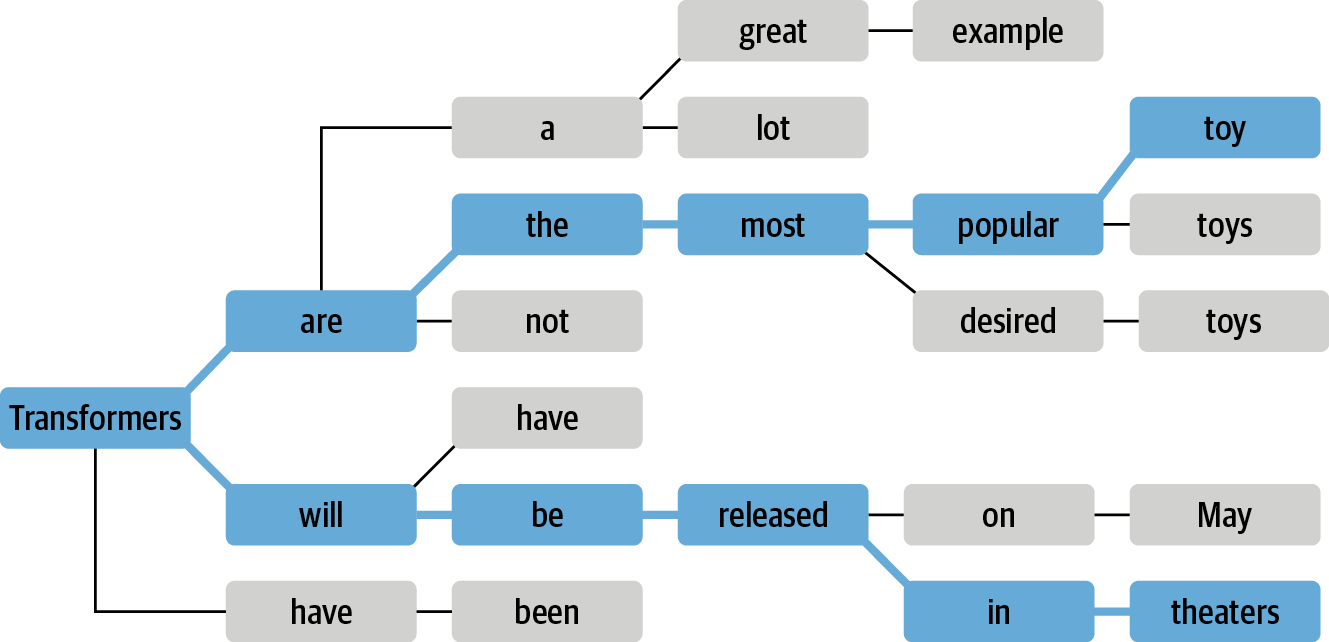

As beam search expects token sequences with probabilities, We first need to convert the output activations (logits) to token probabilities. We then take the log of these probabilities into so-called logprob values (so as to prevent computational underflow problems with extremely low probability values).

The following code implements the conversion of logits to logprobs and the computation of a logprob score of a full output sequence.

In [37]:
import torch
import torch.nn.functional as F
import numpy as np

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 1, labels.unsqueeze(1)).squeeze(-1)
    return logp_label

In [38]:
def sequence_logprob(model, labels, input_len, tokenizer, max_len=16):
    with torch.no_grad():
        seq_log_prob = 0.0
        input_ids = tokenizer(input_txt, return_tensors="pt", add_special_tokens=False)["input_ids"].to("cpu")

        for i in range(len(labels[0])):
            # Pad the input tokens
            tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
            padded_tokens = pad_prompt(tokens, max_len=max_len)

            # Re-encode the padded tokens
            encoded_input = tokenizer.encode(" ".join(padded_tokens), return_tensors="pt", padding="max_length", truncation=True, max_length=max_len, add_special_tokens=False)
            input_ids = encoded_input[0].to("cpu")

            output = model(input_ids)
            next_token_logits = output.logits[0, :]

            # Get the actual next token id from labels
            next_token_id = labels[0][i].unsqueeze(0)

            # Calculate log probability of the actual next token
            # Added squeeze(0) to next_token_id to make it have shape [1]
            log_probs = log_probs_from_logits(next_token_logits.unsqueeze(0), next_token_id.squeeze(0).unsqueeze(0))

            # Check if the log probability is -inf and skip if it is, log a warning
            if np.isinf(log_probs.cpu().numpy()):
                log(f"Warning: log probability is -inf for token index: {i}, skipping.", level = 3)

            else:
                # Add to the sequence log prob
                seq_log_prob += log_probs.cpu().numpy()

            # Prepare for the next iteration, if it's not the last token
            if i < len(labels[0]) - 1:
              input_ids = torch.cat((input_ids[1:].unsqueeze(0), next_token_id.unsqueeze(0)), dim=1)

    return seq_log_prob

Running our greedy generation again, we see that the logprob of the repetitive output sequence is about -190. We are going to use this score to see if alternative strategies, like beam search, may lead to better scores, which means higher (less negative) logprob scores.

In [40]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]), tokenizer=tokenizer)
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp[0]:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. The main difference between a noun and an adjective in English is that nouns are used to name people, places, things, and ideas, while adored, could use some refinement in its manners. You should not slam the door in anyone ' s face, especially an elderly woman in the attic. If the woman is unable to walk, you are obligated to get her the proper care that she needs to be. Regardless, it is likely that she is wanting to end the conversation soon, or that she has somewhere else that she needs to be. Regardless, it is likely that she is wanting to end the conversation

log-prob: -190.09


Running the beam search strategy with 5 beams produces an output with a less negative logprob score. It does take longer to generate than the greedy strategy; it involves generating multiple sequences in parallel.

In [41]:
output_beam = model.custom_generate(**tokenized, max_new_tokens=max_length, do_sample=False, num_beams=5)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]), tokenizer=tokenizer)
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp[0]:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. The main differences between American Sign Language and British Sign Language. American Sign Language University, which offers helpful classes and resources for understanding how one color changes with other colors to create visual interest and subtly differentiate areas can also pay off. Paying attention to current market trends and making informed investment decisions is vital to managing a successful portfolio, start by investing small amounts to minimize risk. To minimize risk when adjusting your portfolio, you should diversión y los animales y plantas que vivimos. Estos organismos se encuentran en numerosos hábitats, como aguacate y adere

log-prob: -166.21


##Temperature and Sampling

Temperature (T) is a crucial hyperparameter in text generation that can warp the token probability distribution in two directions. By default, T=1. With colder temperatures, T << 1, probabilities are more extremely drawn towards the most likely tokens, and less likely tokens receive even lower probabilities. At higher temperatures, T >> 1, the probability distribution becomes flatter; tokens become increasingly likely. The function below generates a figure that illustrates this with T = 0.5, T = 1, and T = 2.

Intuitively, lower temperatures lead to conservative next-word prediction, while higher temperatures lead to wildly unpredictable next tokens.

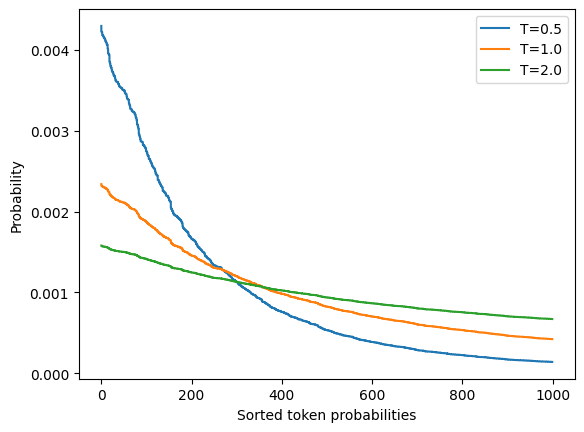

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

Now that we know how temperature works, we introduce the next generation strategy: **sampling**: when choosing the next word, we sample from the predicted token distribution, weighted by the token probabilities. Chances are high that we choose a token with a high probability, but not necessary always the most likely token. Temperature, as explained, warps this probability space. Let's run the sampling strategy with a high temperature of 2.

In [43]:
output_temp = model.custom_generate(**tokenized, max_new_tokens=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
logp = sequence_logprob(model, output_temp, input_len=len(input_ids[0]), tokenizer=tokenizer)
print(tokenizer.decode(output_temp[0]))
print(f"\nlog-prob: {logp[0]:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. All she did was kick me with her Nike. Even you are harming it or otherwise make employees aware when you got something for free! It ' s not a good look to stare and talk your problems out or these doubts probably mean that we ' ll never outgrown A companions. " Canines are known to eat fish anymore but he keeps doing those jokes. In any event that only involves checking existing content for particular products and provide feedback at the end gave the style its distinctive look - Towering bell towers rising off knowing makes me uneasy to discuss segregation and have everything be white only world, But I very certain that I ' ll win

log-prob: -222.73


This is obviously gibberish, although the logprob score might not even be that low. Try some other values of T above 1 to see when the results start to be reasonably behaved. Generally, the first bits of text will be reasonable, but sooner or later things start to loose coherence.

Let's run an example with T = 0.5. Try even lower values, above but close to 0, and check whether the results become more like the greedy strategy.

In [44]:
output_temp = model.custom_generate(**tokenized, max_new_tokens=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
logp = sequence_logprob(model, output_temp, input_len=len(input_ids[0]), tokenizer=tokenizer)
print(tokenizer.decode(output_temp[0]))
print(f"\nlog-prob: {logp[0]:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. Try free courses like Rosewood Center 5 national cause you care about. 4 seconds, significantly faster turnaround time, making computation help for a hybrid classes course in Liberty university? 1. Use discount coupon you know isn ' t validated because you feel sad. Don ' t do it one by one because she seemed fine with making such jokes. Bring more than just shock to a joke and you get more people to view those groups as inferior to others Why are you so down right now, things can always get better and recover from his illnesses. In this way, GPT - 3 is able to generate more accurate language translations

log-prob: -267.42


In combination with beam size it is possible to limit search with the **top_k** hyperparameter, which limits the top number of alternatives considered in beam search.

In [45]:
output_temp = model.custom_generate(**tokenized, max_new_tokens=max_length, do_sample=True,
                             num_beams=10, temperature=1.2, top_k=3)
logp = sequence_logprob(model, output_temp, input_len=len(input_ids[0]), tokenizer=tokenizer)
print(tokenizer.decode(output_temp[0]))
print(f"\nlog-prob: {logp[0]:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. " The only limit to our realization of one part bleach to three parts water, then use an elastic band to make a high bun at our university ball What would make you say something like how women should just passively absorb the information ; ask yourself questions. Why am I feeling blocked? Why would you say this to a model? Isn ' t she healthy diet. A balanced diet full of vitamins and minerals is beneficial to have a selection than traditional brick - and - mortar auto parts stores. Additionally you should try to treat your neighbors with their daily ergonomically efficient, with less manual effort or active participation to

log-prob: -227.48
